In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

import sqlalchemy as sa
import sqlalchemy.orm as sa_orm

from eval.db.orm.models import Args, Benchmark, Quast, Run
from eval.db.context import create_engine

ArgsTbl = Args.__table__
BenchmarkTbl = Benchmark.__table__
QuastTbl = Quast.__table__
RunTbl = Run.__table__

sns.set_theme(style="dark")

DB_PATH = Path('./2022-11-27.db')
ENGINE_URI = create_engine(DB_PATH)
Session = sa_orm.sessionmaker(ENGINE_URI)


In [2]:
CAMEL_VERSION = '0.8.1'
RACON_VERSION = '1.5.0'

colors = {
    f'camel {CAMEL_VERSION}': '#ff6600',
    f'racon {RACON_VERSION}': '#01588a'
}


<AxesSubplot: xlabel='window_length', ylabel='peak_memory_mib'>

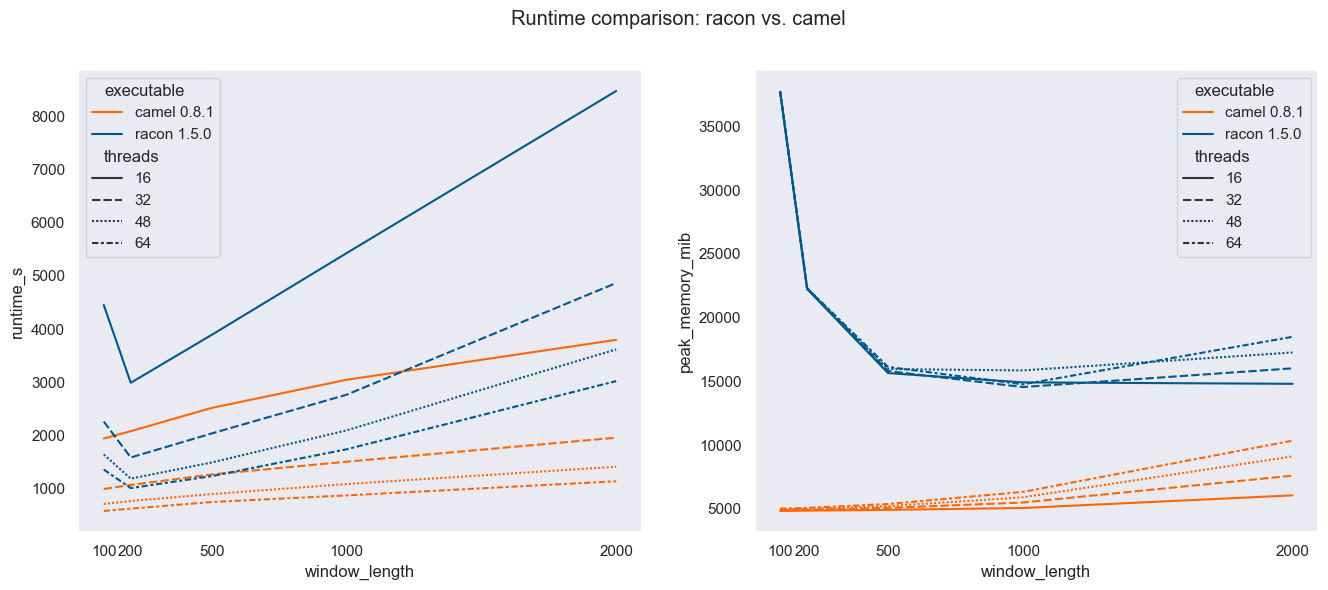

In [3]:
query = sa.select(
    RunTbl.c.id,
    sa.type_coerce(RunTbl.c.executable +
                   ' ' +
                   RunTbl.c.version, sa.String).label('executable'),
    ArgsTbl.c.window_length,
    BenchmarkTbl.c.threads,
    BenchmarkTbl.c.runtime_s,
    BenchmarkTbl.c.peak_memory_mib,
).select_from(
    RunTbl.outerjoin(
        ArgsTbl, RunTbl.c.id == ArgsTbl.c.run_id).outerjoin(
            BenchmarkTbl, RunTbl.c.id == BenchmarkTbl.c.run_id)).where(
    sa.or_(
        sa.and_(RunTbl.c.executable == 'camel',
                RunTbl.c.version == CAMEL_VERSION),
        sa.and_(RunTbl.c.executable == 'racon',
                RunTbl.c.version == RACON_VERSION)))

with Session() as dbsession:
    df = pd.read_sql(query, dbsession.bind)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Runtime comparison: racon vs. camel')

axes[0].set_xticks(df.window_length.unique())
sns.lineplot(data=df, x='window_length', y='runtime_s',
             hue='executable', style='threads', palette=colors, ax=axes[0])

axes[1].set_xticks(df.window_length.unique())
sns.lineplot(data=df, x='window_length', y='peak_memory_mib',
             hue='executable', style='threads', palette=colors, ax=axes[1])


In [4]:
query = sa.select(
    RunTbl.c.id,
    sa.type_coerce(RunTbl.c.executable +
                   ' ' +
                   RunTbl.c.version, sa.String).label('executable'),
    ArgsTbl.c.window_length,
    ArgsTbl.c.error_threshold,
    BenchmarkTbl.c.threads,
    QuastTbl.c.n_contigs,
    QuastTbl.c.largest_contig,
    QuastTbl.c.N50,
    QuastTbl.c.NG50,
    QuastTbl.c.NA50,
    QuastTbl.c.NGA50,
    QuastTbl.c.mismatches_per_100kbp,
    QuastTbl.c.indels_per_100kbp,
    QuastTbl.c.largest_alignment,
    QuastTbl.c.total_aligned_length,
).select_from(
    RunTbl.outerjoin(
        ArgsTbl, RunTbl.c.id == ArgsTbl.c.run_id).outerjoin(
            BenchmarkTbl, RunTbl.c.id == BenchmarkTbl.c.run_id).outerjoin(
                QuastTbl, RunTbl.c.id == QuastTbl.c.run_id)).where(
    sa.or_(
        sa.and_(RunTbl.c.executable == 'camel',
                RunTbl.c.version == CAMEL_VERSION),
        sa.and_(RunTbl.c.executable == 'racon',
                RunTbl.c.version == RACON_VERSION)))

with Session() as dbsession:
    df = pd.read_sql(query, dbsession.bind)

filtered = df.loc[(df['threads'] == 64), df.columns.drop(['id', 'threads'])]
filtered


,executable,window_length,error_threshold,n_contigs,largest_contig,N50,NG50,NA50,NGA50,mismatches_per_100kbp,indels_per_100kbp,largest_alignment,total_aligned_length
30,camel 0.8.1,100,0.3,25,1156268,768061,1156268,-,148967,1022.81,2053.31,148967,260458
31,racon 1.5.0,100,0.3,26,1338356,797223,1338356,-,186552,1079.66,1289.78,186552,388826
32,camel 0.8.1,200,0.3,26,1076764,773038,1076764,-,154069,1103.96,1952.65,154069,301641
33,racon 1.5.0,200,0.3,22,1076267,801921,1076267,-,194745,1036.12,1183.67,194745,337509
34,camel 0.8.1,500,0.3,21,1508745,799626,1508745,-,149534,1219.38,2005.37,149534,287278
35,racon 1.5.0,500,0.3,24,1082147,806734,1082147,-,195841,1178.22,1132.20,195841,388976
36,camel 0.8.1,1000,0.3,20,1502460,901073,1502460,-,170636,1200.40,2043.10,170636,285987
37,racon 1.5.0,1000,0.3,23,1500897,799696,1500897,-,197220,981.89,1204.83,197220,365114
38,camel 0.8.1,2000,0.3,23,1072929,800136,1072929,-,138470,1316.29,2222.49,138470,249945
39,racon 1.5.0,2000,0.3,33,1074047,646092,1074047,-,182605,950.91,1237.13,182605,379428


<AxesSubplot: xlabel='window_length', ylabel='n_contigs'>

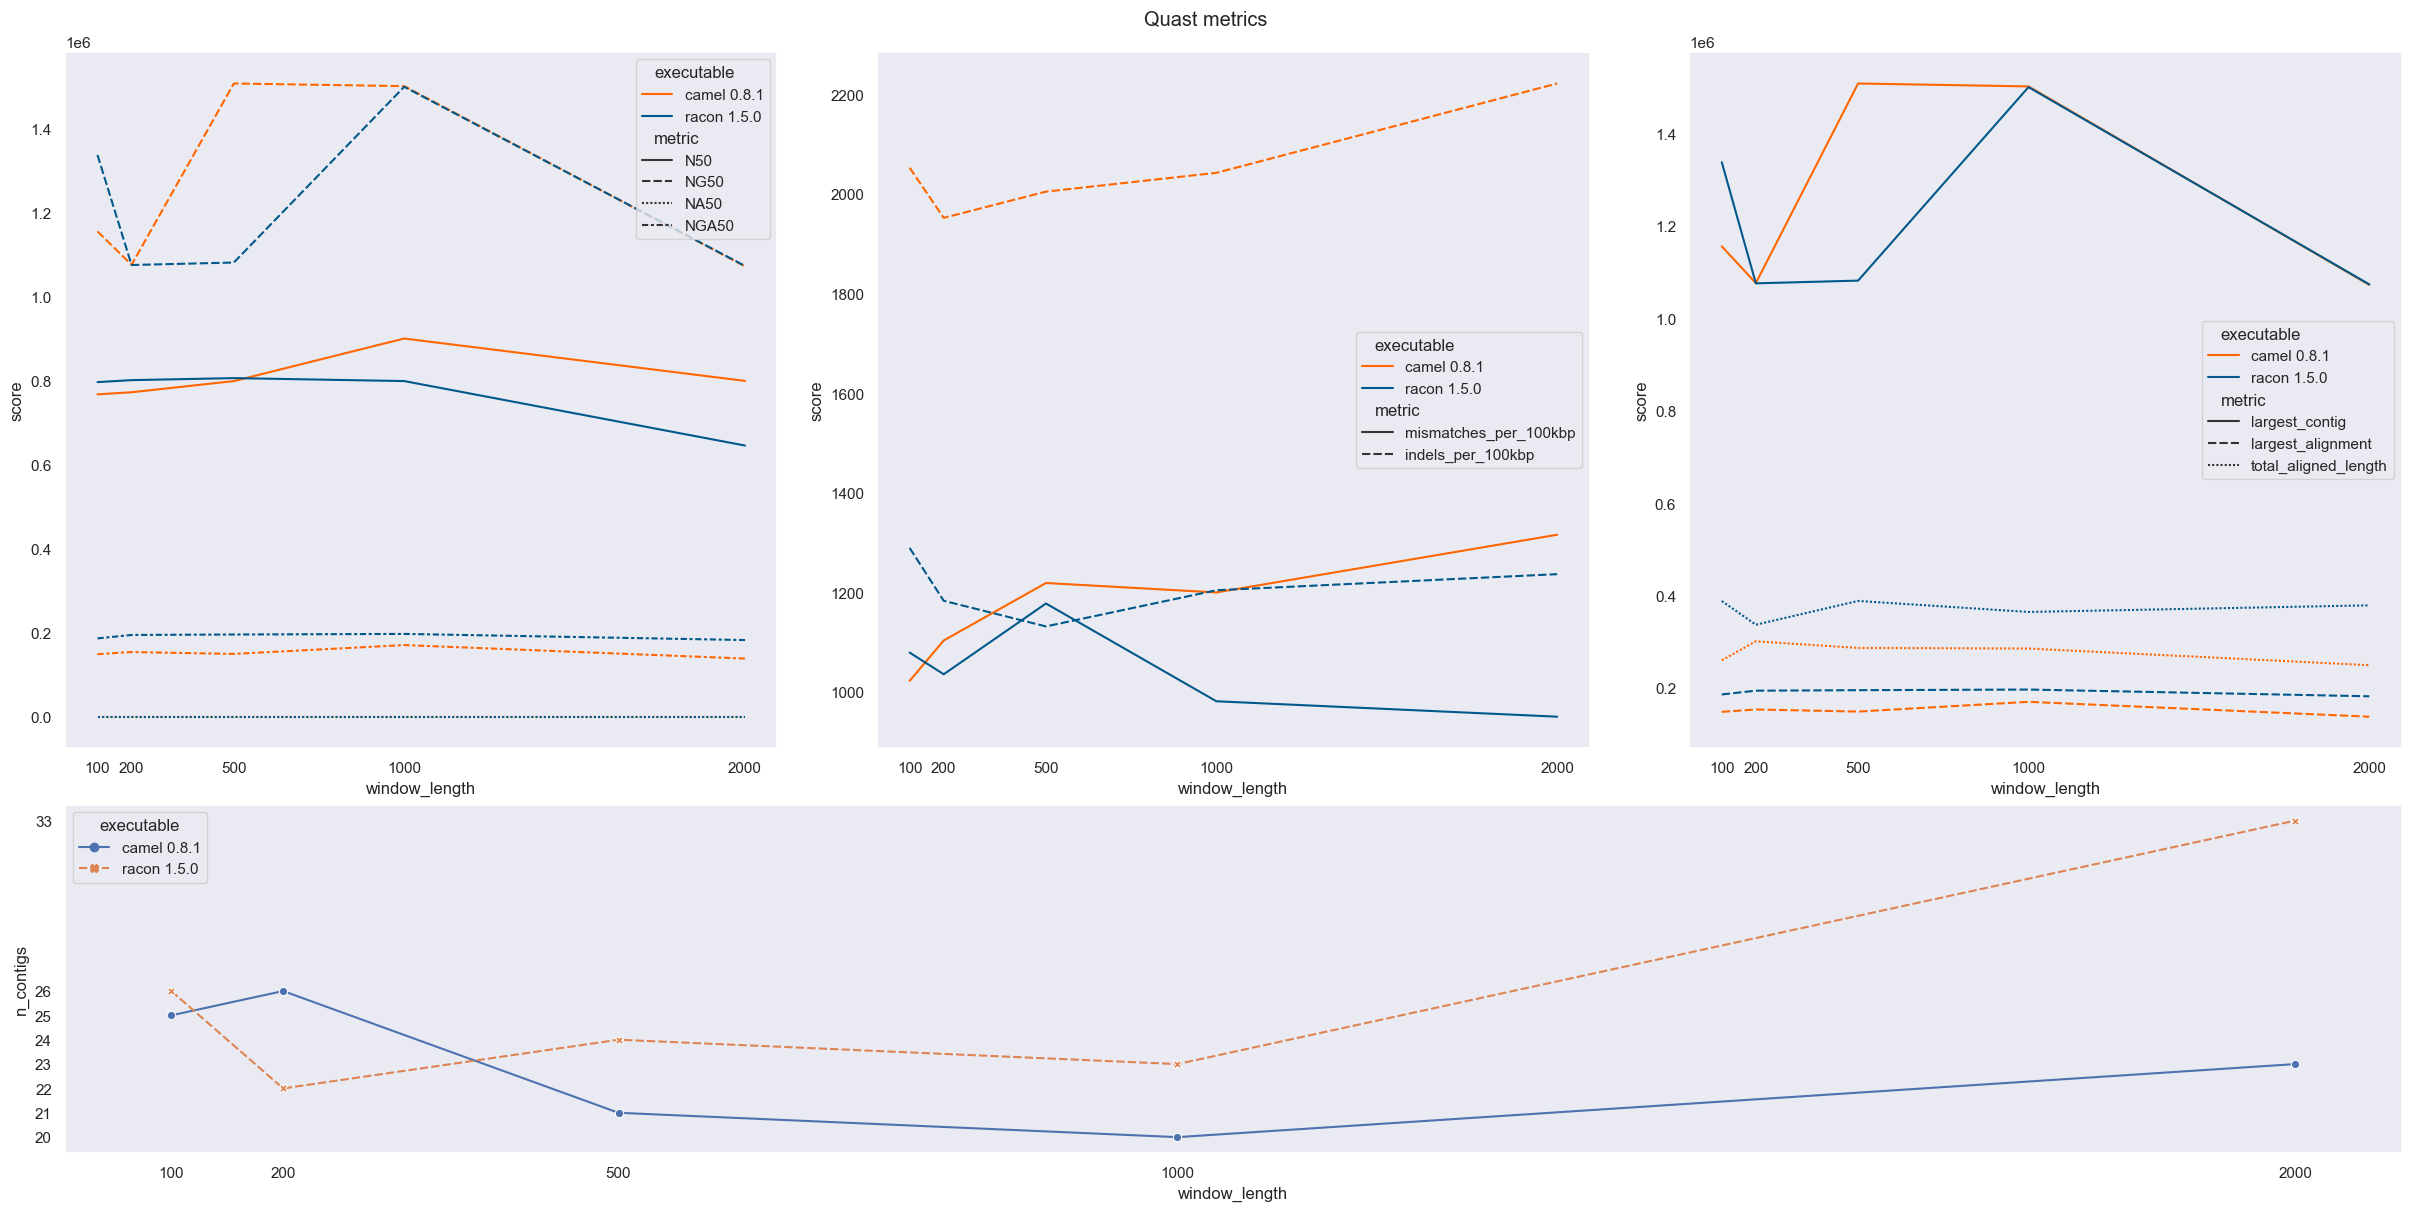

In [5]:
shared_columns = ['executable', 'window_length']
alignment_columns = ['largest_contig',
                     'largest_alignment', 'total_aligned_length']
n_columns = ['N50', 'NG50', 'NA50', 'NGA50']
identity_columns = ['mismatches_per_100kbp', 'indels_per_100kbp']


def create_long_table(value_columns):
    return filtered[shared_columns + value_columns].melt(
        id_vars=shared_columns, var_name='metric', value_name='score')


fig = plt.figure(constrained_layout=True, figsize=(24, 12))
fig.suptitle('Quast metrics')

ax0 = [plt.subplot2grid((3, 3), (0, i), rowspan=2, colspan=1) for i in range(3)]
ax1 = plt.subplot2grid((3, 3), (2, 0), rowspan=1, colspan=3)


def create_lineplot(df, ax_idx):
    ax0[ax_idx].set_xticks(df.window_length.unique())
    sns.lineplot(df, x='window_length', y='score',
                 style='metric', hue='executable', palette=colors, ax=ax0[ax_idx])


n_long = create_long_table(n_columns)
n_long.loc[n_long['score'] == '-', 'score'] = 0
create_lineplot(n_long, 0)

identity_long = create_long_table(identity_columns)
create_lineplot(identity_long, 1)


alignment_long = create_long_table(alignment_columns)
create_lineplot(alignment_long, 2)


df_contigs = filtered[['executable', 'window_length' ,'n_contigs']]

ax1.set_xticks(df_contigs.window_length.unique())
ax1.set_yticks(df_contigs.n_contigs.unique())
sns.lineplot(df_contigs, x='window_length', y='n_contigs', hue='executable', ax=ax1, markers=True, style='executable')